In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from eunjeon import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [250]:
csv_name = './test_category'
train_data = pd.read_csv(csv_name+".csv")
train_data = pd.DataFrame(train_data)
train_data

,Unnamed: 0,Post,score,AD,keyword score,tfidf score,josa,noun,noun/josa,paragraph num
0,1,취미생활 하고 싶어 꽃친 미니어쳐 집짓기저의 딸래미가 순식간에 뚝딱 집한채 졌답니다...,1,1,1.691729,3.139594,0.156382,0.295858,1.89,525
1,2,제목 그대로 입니다화장실 목욕탕 환풍기가 굉음 소리를 내면서 고장이 났네요회전...,2,1,9.943182,4.473089,0.145722,0.342246,2.35,356
2,3,학업이나 직장을 위해 얻는 임시 주거지가 되는 자취방 인테리어는 대부분 소규모의 원...,1,1,3.506098,4.126646,0.186029,0.359909,1.93,800
3,4,얼마 전 울 집 주방에서 사용하던 인덕션 교체를 하게 되었거든요기존에 사용하던 빌트...,3,1,8.307692,2.260273,0.132716,0.368827,2.78,599
4,5,안녕하세요 작은기쁨입니다 오랜만에 포스팅으로 인사드려요역시나 이번에도 캠핑용품 인...,2,0,9.951846,1.985994,0.161049,0.321348,2.00,566
...,...,...,...,...,...,...,...,...,...,...
1688,1689,토요일 배송된 보석십자수 택배박스를 개봉하면요렇게 귀여운 박스가 나와요저는 타타를 ...,2,1,10.909091,0.579664,0.143460,0.316456,2.21,86
1689,1690,핸드폰 갤러리 보다가 발견한 백수 때 했던 뻘짓들그래도 나름 뿌듯해서 모아봄 글라스...,3,1,8.780488,0.631065,0.109865,0.334081,3.04,225
1690,1691,비즈십자수 용그림이에요보석비즈십자수 큐빅 한알한알 박으셔서더 정성스러워요 ...,4,1,10.714286,2.154564,0.101942,0.427184,4.19,53
1691,1692,안녕하세요비가 옵니다춥네요이웃님들 모두 감기 걸리지 않게조심하세요 모기도 벌써부...,3,1,9.090909,-1.318872,0.063158,0.294737,4.67,64


<AxesSubplot:>

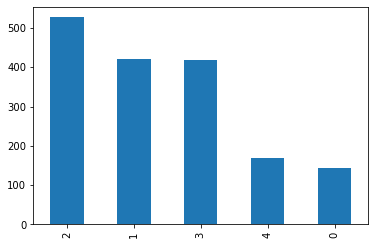

In [251]:
train_data.drop_duplicates(subset=['Post'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
train_data['score'].value_counts().plot(kind = 'bar')

<ipython-input-252-0d18f4506655>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['score'] = np.where(target['score']>=3, 4, target['score'])
<ipython-input-252-0d18f4506655>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['score'] = np.where(target['score']<=1, 2, target['score'])
<ipython-input-252-0d18f4506655>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

<AxesSubplot:>

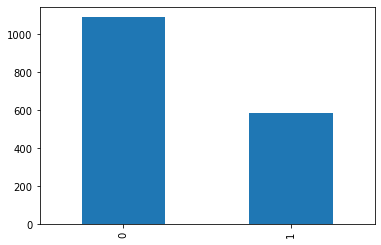

In [252]:
target = train_data[['score']]
target['score'] = np.where(target['score']>=3, 4, target['score'])
target['score'] = np.where(target['score']<=1, 2, target['score'])
target['score'] = np.where(target['score']==2, 0, target['score'])
target['score'] = np.where(target['score']==4, 1, target['score'])
target['score'].value_counts().plot(kind = 'bar')

In [253]:
print(train_data.isnull().values.any())

False


In [254]:
train_data['Post'] = train_data['Post'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-254-f2e5e28ae253>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['Post'] = train_data['Post'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [255]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt=Mecab()

X_train = []
for sentence in train_data['Post']:
    temp_X = okt.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords if len(word)>1] # 불용어 제거
    X_train.append(temp_X)

In [256]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [257]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 21279
등장 빈도가 2번 이하인 희귀 단어의 수: 11507
단어 집합에서 희귀 단어의 비율: 54.07678932280652
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1045164381920554


In [258]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 9773


In [259]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [260]:
y_train = np.asarray(target['score']).astype(float)
print(y_train)

[0. 0. 0. ... 1. 1. 0.]


In [261]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# y_train = np_utils.to_categorical(y_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
print(y_train)

[1. 1. 0. ... 0. 0. 1.]


In [262]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(X_test))

1341
336


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [263]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [264]:
max_len = 700
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 700 이하인 샘플의 비율: 98.73228933631619


리뷰의 최대 길이 : 1789
리뷰의 평균 길이 : 273.0141685309471


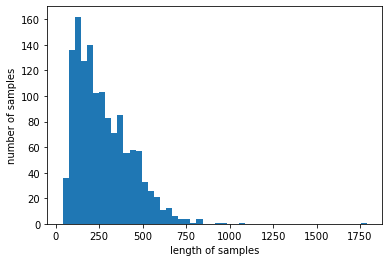

In [265]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [266]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [267]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [268]:
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [269]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [270]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=3, validation_split=0.3) #callbacks=[es, mc],

Epoch 1/10
313/313 [==============================] - 107s 334ms/step - loss: 0.6176 - acc: 0.6930 - val_loss: 0.5609 - val_acc: 0.7122

Epoch 00001: val_loss improved from inf to 0.56093, saving model to best_model.h5
Epoch 2/10
313/313 [==============================] - 101s 323ms/step - loss: 0.4639 - acc: 0.8006 - val_loss: 0.5830 - val_acc: 0.7146

Epoch 00002: val_loss did not improve from 0.56093
Epoch 3/10
313/313 [==============================] - 100s 320ms/step - loss: 0.3614 - acc: 0.8678 - val_loss: 0.7159 - val_acc: 0.7146

Epoch 00003: val_loss did not improve from 0.56093
Epoch 4/10
313/313 [==============================] - 99s 317ms/step - loss: 0.3443 - acc: 0.8785 - val_loss: 0.8201 - val_acc: 0.6625

Epoch 00004: val_loss did not improve from 0.56093
Epoch 5/10
313/313 [==============================] - 99s 316ms/step - loss: 0.2264 - acc: 0.9254 - val_loss: 0.7996 - val_acc: 0.6873

Epoch 00005: val_loss did not improve from 0.56093
Epoch 00005: early stopping


In [271]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

11/11 [==============================] - 3s 195ms/step - loss: 0.6366 - acc: 0.6488

 테스트 정확도: 0.6488
